In [1]:
from Ornstein_Uhlenbeck import Ornstein_Uhlenbeck
import backtrader as bt
import numpy as np
import pandas as pd
import pyfolio as pf

/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
stock_list = ['SLV', 'SIL']
stock_dict = {}
for stock in stock_list:
    stock_dict[stock] = pd.read_csv('data/{}.csv'.format(stock), index_col='Date', parse_dates=['Date'])

In [3]:
class PandasData(bt.feeds.PandasData):
    lines = ('open', 'high', 'low', 'close', 'adjclose', 'volume')
    params = (('datetime', None),
              ('open', 0),
              ('high', 1),
              ('low', 2),
              ('close', 3),
              ('adjclose', 4),
              ('volume', 5))

In [4]:
class MyStrategy(bt.Strategy):
    def __init__(self):
        self.St = {stock_list[0]: np.array([]),
                   stock_list[1]: np.array([])
                   }
        self.model = Ornstein_Uhlenbeck(stock_dict[stock_list[0]]['Close'].to_numpy(), 
                                        stock_dict[stock_list[1]]['Close'].to_numpy())
        self.a = 0.1
        self.signal = 0
        self.pos = 0
    
    def signal_generation(self):
        if len(self.St[stock_list[0]]) < 252:
            return 0
        self.Xt = self.model.alpha * self.St[stock_list[0]][-1] - self.model.beta * self.St[stock_list[1]][-1]
        if self.signal == 1:
            signal = 0 if self.Xt >= self.model.mu else 1
        elif self.signal == -1:
            signal = 0 if self.Xt <= self.model.mu else -1
        else:
            if self.Xt > np.quantile(self.model.X, 1 - self.a):
                signal = -1
            elif self.Xt < np.quantile(self.model.X, self.a):
                signal = 1
            else:
                signal = 0
        return signal
        
    def close_positions(self):
        for data in self.datas:
            self.close(data=data)
            
    def next(self):
        for data in self.datas:
            self.St[data._name] = np.append(self.St[data._name], data.close[0])

        if len(self.St[stock_list[0]]) != 0 and len(self.St[stock_list[0]]) % 252 == 0:
            self.model = Ornstein_Uhlenbeck(self.St[stock_list[0]][-252:], self.St[stock_list[1]][-252:])
            
        self.signal = self.signal_generation()
    
        if self.signal == 1:
            if self.pos == 0:
                self.buy(data=self.datas[0], size=cerebro.broker.get_value() * self.model.alpha)
                self.sell(data=self.datas[1], size=cerebro.broker.get_value() * self.model.beta)
                print("{}: Long pair when Xt = {}".format(self.data.datetime.date(), self.Xt))
        elif self.signal == -1:
            if self.pos == 0:
                self.sell(data=self.datas[0], size=cerebro.broker.get_value() * self.model.alpha)
                self.buy(data=self.datas[1], size=cerebro.broker.get_value() * self.model.beta)
                print("{}: Short pair when Xt = {}".format(self.data.datetime.date(), self.Xt))
        elif self.signal == 0:
            if self.pos != 0:
                self.close_positions()
                print("{}: Close pair when Xt = {}".format(self.data.datetime.date(), self.Xt))
        self.pos = self.signal

In [5]:
cerebro = bt.Cerebro()

data_feed_dict = {}
for stock in stock_list:
    data_feed_dict[stock] = PandasData(dataname=stock_dict[stock], name=stock)
    cerebro.adddata(data_feed_dict[stock])

cerebro.addstrategy(MyStrategy)
cerebro.broker.setcash(100000000)
cerebro.broker.setcommission(commission=0.001)

In [6]:
# Run the backtest
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
results = cerebro.run()
pyfolio_analyzer = results[0].analyzers.pyfolio
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

2014-12-31: Long pair when Xt = 0.49199101301646103
2015-01-16: Close pair when Xt = 0.5506570468703982
2015-02-18: Long pair when Xt = 0.5061768971417353
2015-03-20: Close pair when Xt = 0.5521923555493
2015-04-24: Long pair when Xt = 0.5124288422975813
2015-05-14: Close pair when Xt = 0.5620971718626708
2015-06-10: Long pair when Xt = 0.5143155026219454
2015-10-05: Close pair when Xt = 0.5504382522540271
2015-11-11: Long pair when Xt = 0.5096466225180268
2016-01-13: Close pair when Xt = 0.6099511744513217
2016-01-20: Short pair when Xt = 0.6382137814707189
2016-02-19: Close pair when Xt = 0.5941917595516897
2016-02-26: Long pair when Xt = 0.5531593373381591
2017-02-15: Close pair when Xt = 0.7902285197362431
2017-02-24: Short pair when Xt = 0.8307905502545695
2017-05-01: Close pair when Xt = 0.7788799666362339
2017-05-09: Long pair when Xt = 0.7361364217801538
2017-05-26: Close pair when Xt = 0.7849577032401523
2017-07-03: Long pair when Xt = 0.7389432803212591
2017-08-09: Close pair

/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in divide
  np.divide(
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib

                    In-sample Out-of-sample        All
Annual return            0.0%          4.6%       4.2%
Cumulative returns       0.0%         50.4%      50.4%
Annual volatility        0.0%         21.0%      19.9%
Sharpe ratio              NaN      0.319633   0.303204
Calmar ratio              NaN      0.142084   0.127561
Stability                 0.0       0.72972   0.801699
Max drawdown             0.0%        -32.7%     -32.7%
Omega ratio               NaN      1.073389   1.073389
Sortino ratio             NaN      0.494519     0.4691
Skew                      NaN      2.066738   2.184972
Kurtosis                  NaN     45.206912  50.586904
Tail ratio                NaN       1.01601   1.035847
Daily value at risk      0.0%         -2.6%      -2.5%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,32.68,2020-07-22,2021-02-22,NaT,NaN
1,20.24,2016-03-01,2016-08-22,2017-11-30,458
2,15.38,2020-04-06,2020-05-04,2020-07-22,78
3,12.79,2019-07-22,2019-09-04,2019-12-04,98
4,8.73,2019-12-13,2020-03-13,2020-03-16,67


Worst drawdown periods Net drawdown in %  Peak date Valley date Recovery date  \
0                              32.683591 2020-07-22  2021-02-22           NaT   
1                              20.243869 2016-03-01  2016-08-22    2017-11-30   
2                              15.379275 2020-04-06  2020-05-04    2020-07-22   
3                              12.788012 2019-07-22  2019-09-04    2019-12-04   
4                               8.733376 2019-12-13  2020-03-13    2020-03-16   

Worst drawdown periods Duration  
0                           NaN  
1                           458  
2                            78  
3                            98  
4                            67  


/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/timeseries.py:1139: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  cone_bounds = pd.DataFrame(columns=pd.Float64Index([]))
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/timeseries.py:1139: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  cone_bounds = pd.DataFrame(columns=pd.Float64Index([]))
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/plotting.py:1302: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.boxplot(data=[is_returns, is_weekly, is_monthly],
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/plotting.py:1318: UserWarning: set_tic

Stress Events,mean,min,max
Apr14,0.00%,0.00%,0.00%
Oct14,0.00%,0.00%,0.00%
Fall2015,-0.03%,-1.50%,1.17%
New Normal,0.02%,-14.03%,20.59%


Stress Events      mean        min        max
Apr14          0.000000   0.000000   0.000000
Oct14          0.000000   0.000000   0.000000
Fall2015      -0.034016  -1.498496   1.172583
New Normal     0.023959 -14.034326  20.588353


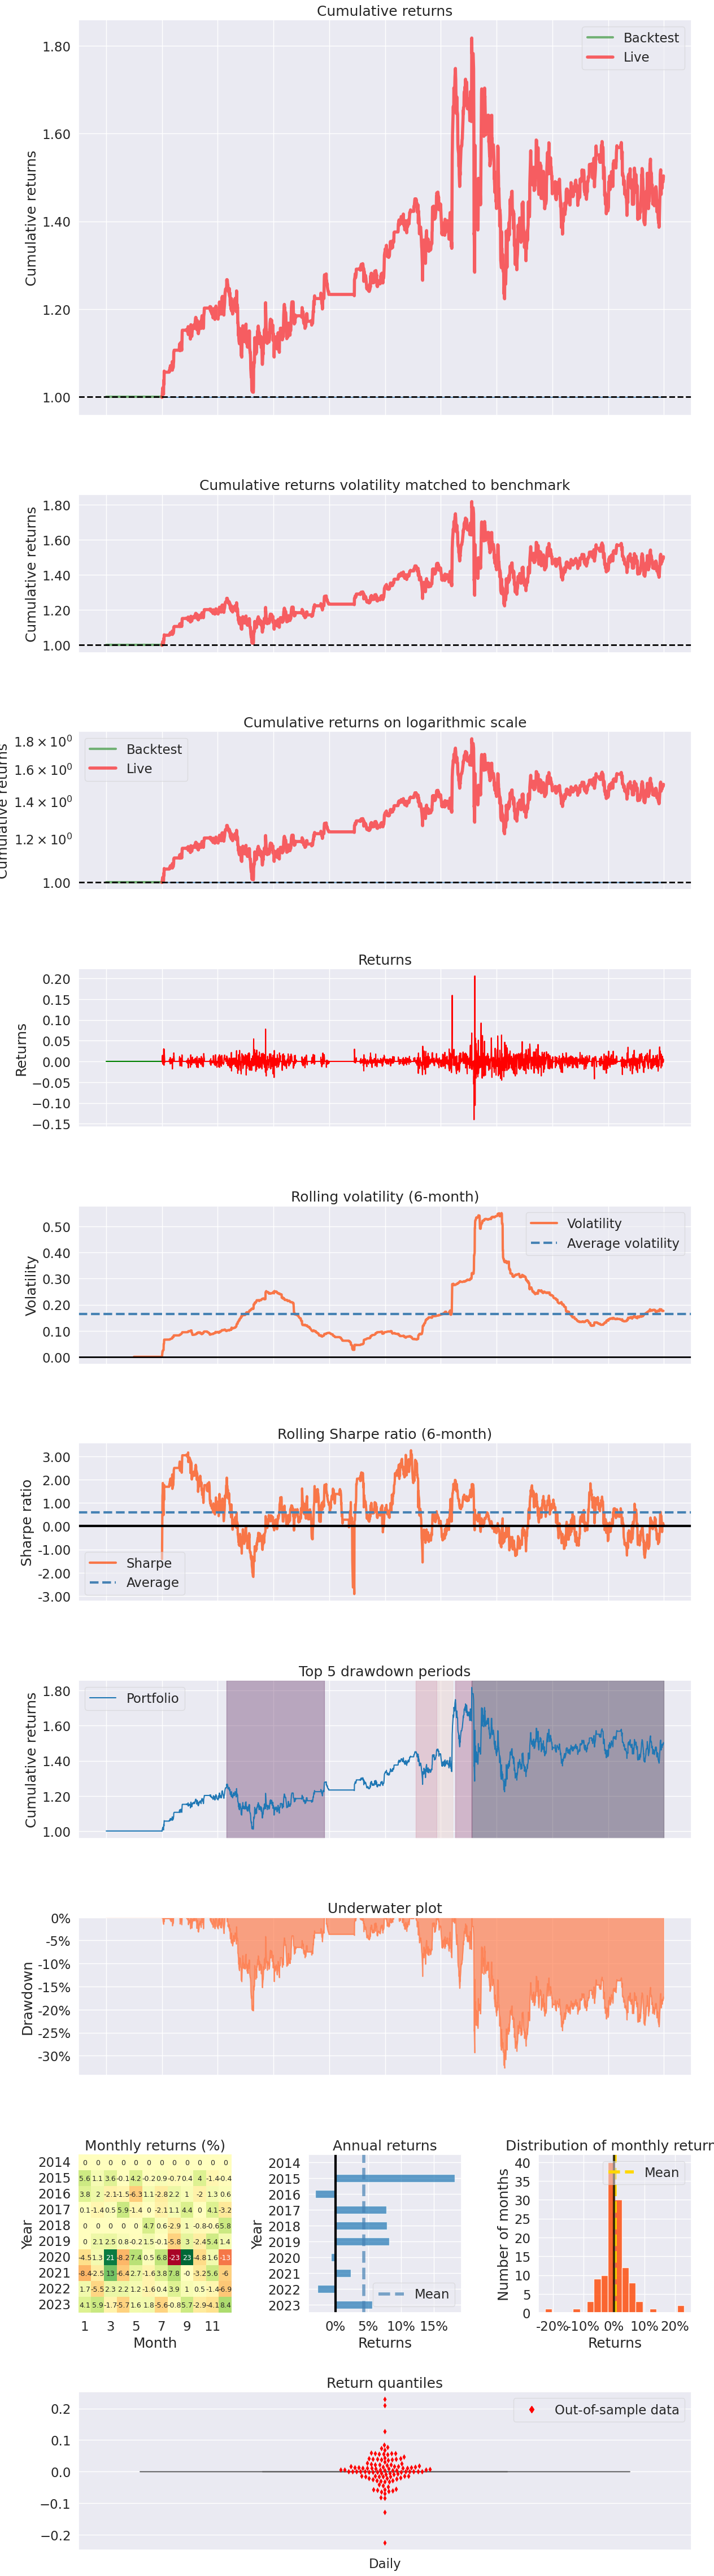

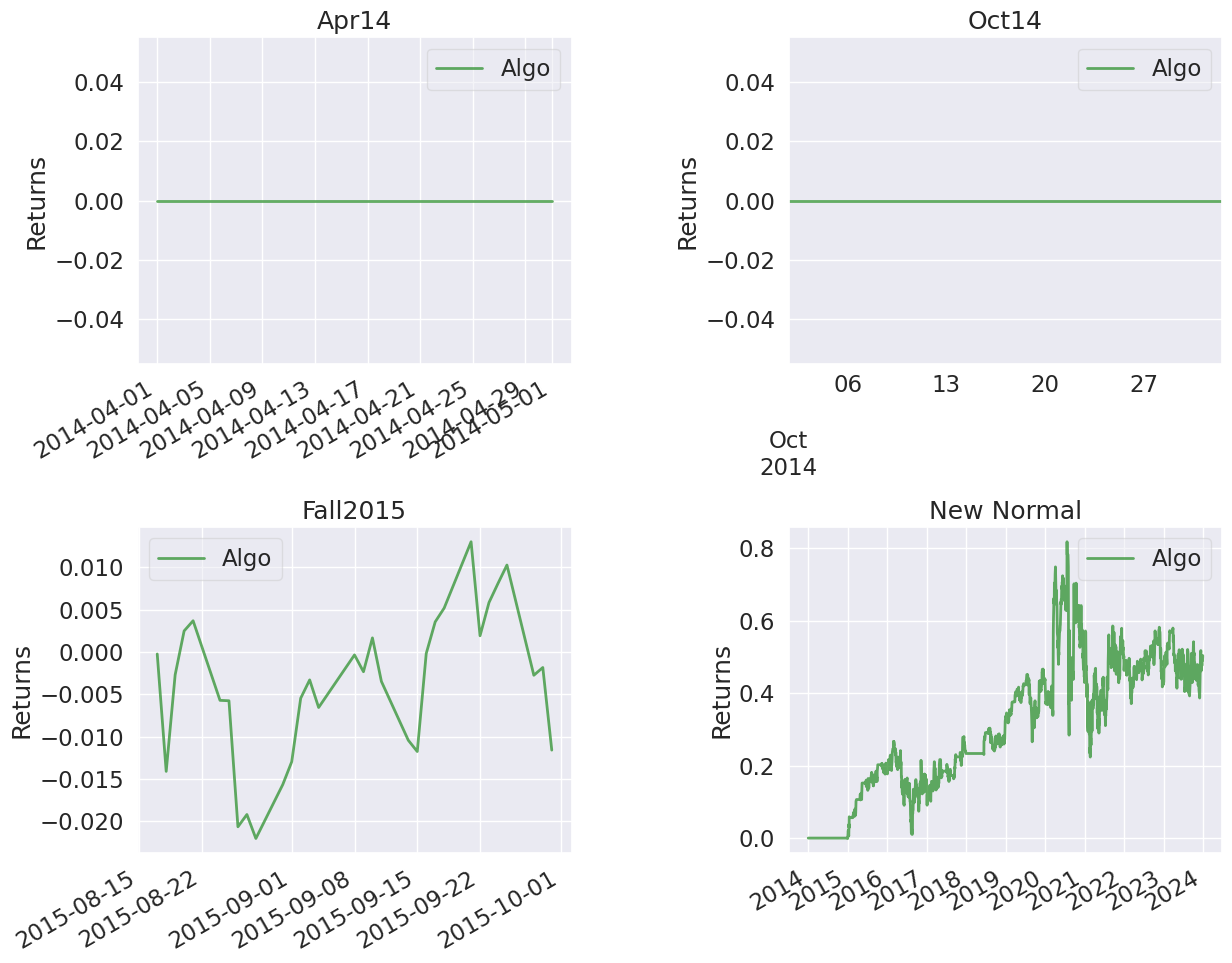

In [7]:
pf.create_full_tear_sheet(returns, live_start_date=stock_dict[stock_list[0]]['Close'].index[252])